# Notebook for the analysis of XPS data 

Analysis of `dati/Al_Sm_30V_3d.csv`

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


In [3]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [4]:
data_path = 'dati/Al_Ag_50V_fullspctra.csv'
data_path = 'dati/Al_Sm_30V_3d.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,440.0,438.52,11104,1316,1633,1686,1702,1548,1611,1608
1,439.7,438.26,10733,1358,1611,1566,1534,1527,1599,1538
2,439.4,437.97,10780,1434,1512,1573,1584,1595,1535,1547
3,439.1,437.71,10825,1404,1509,1631,1555,1593,1533,1600
4,438.8,437.37,10888,1352,1616,1609,1549,1487,1619,1656
...,...,...,...,...,...,...,...,...,...,...
263,361.2,360.52,14236,1951,2026,2037,2036,2105,2117,1964
264,360.9,360.24,14447,2014,2114,2025,2139,2055,2131,1969
265,360.6,359.96,14419,1999,2072,2116,1939,2187,2056,2050
266,360.3,359.68,14686,2097,2128,2118,2199,2027,2066,2051


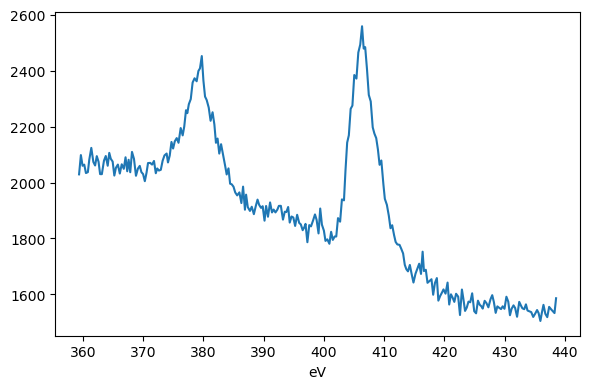

In [5]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

In [6]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(370, 414, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)

test_model =  LorentzianModel(prefix="a_") + LorentzianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 405, "max":410, "min":400 },
        "b_center": {"value": 375, "max":382, "min":378},
    }
)
result.plot()
result

ValueError: Inclusive has to be either string of 'both','left', 'right', or 'neither'.

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_1617/2223888770.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,6069.269,0.000,inf,inf,True,,
a_center,406.870,-inf,inf,inf,True,,
a_fwhm,4.942,-inf,inf,inf,False,2.0000000*a_sigma,
a_height,781.777,-inf,inf,inf,False,"0.3183099*a_amplitude/max(1e-15, a_sigma)",
a_sigma,2.471,1.400,2.500,inf,True,,
b_amplitude,5659.253,0.000,inf,inf,True,,
b_center,379.728,-inf,inf,inf,True,,
b_fwhm,7.260,-inf,inf,inf,False,2.0000000*b_sigma,
b_height,496.272,-inf,inf,inf,False,"0.3183099*b_amplitude/max(1e-15, b_sigma)",
b_sigma,3.630,0.000,inf,inf,True,,


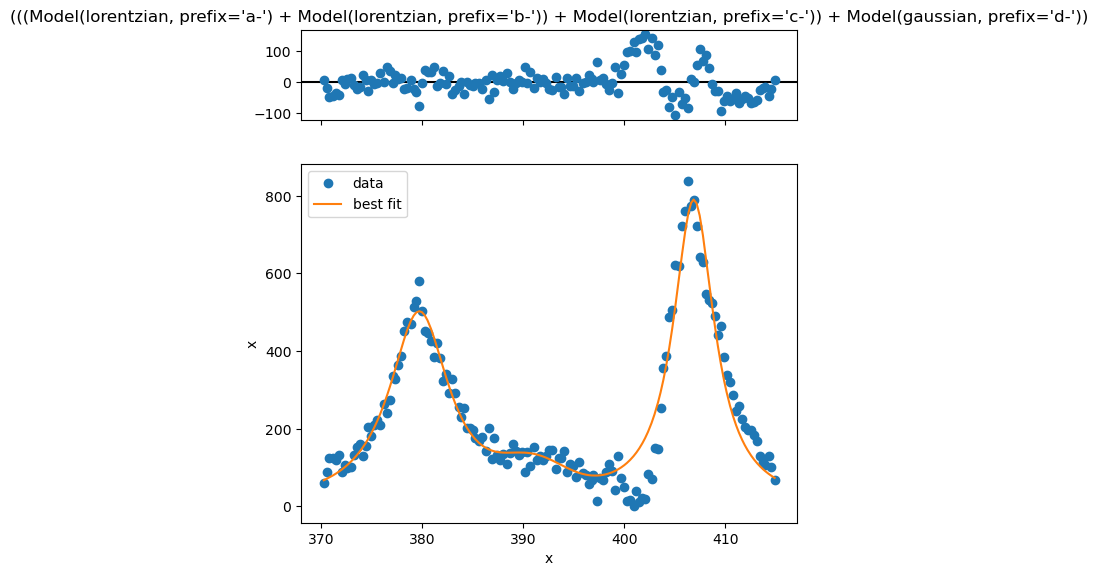

In [6]:
# test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
# test_curve = remove_shirley_background(test_curve)

selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)
#test_curve = remove_shirley_background(test_curve)

test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = LorentzianModel(prefix="a_") + LorentzianModel(prefix="b_") + LorentzianModel(prefix="c_") + GaussianModel(prefix="d_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
        "a_center": {"value": 405 },
        "a_sigma": {"value": 1.5, "max": 2.5, "min": 1.4},
        "a_amplitude": {"min": 0},
        "b_center": {"value": 375},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 398, "max": 399, "min":397},
        "c_amplitude": {"min": 0.3},
        "c_sigma":{"max": 3, "min": 1},
        "d_center": {"value": 393, "max": 396, "min":391},
        "d_amplitude": {"min": 0},
        "d_sigma":{"max": 10, "min": 1},
    }

)
result.plot()
result

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_1617/934261648.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,3502.903,0.000,inf,374.900,True,,
a_center,406.364,-inf,inf,0.156,True,,
a_fwhm,4.454,-inf,inf,0.207,False,2.3548200*a_sigma,
a_height,738.822,-inf,inf,49.371,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,1.891,1.400,2.500,0.088,True,,
b_amplitude,3753.253,0.000,inf,230.915,True,,
b_center,379.729,-inf,inf,0.123,True,,
b_fwhm,7.447,-inf,inf,0.419,False,2.3548200*b_sigma,
b_height,473.475,-inf,inf,10.238,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,3.162,0.000,inf,0.178,True,,


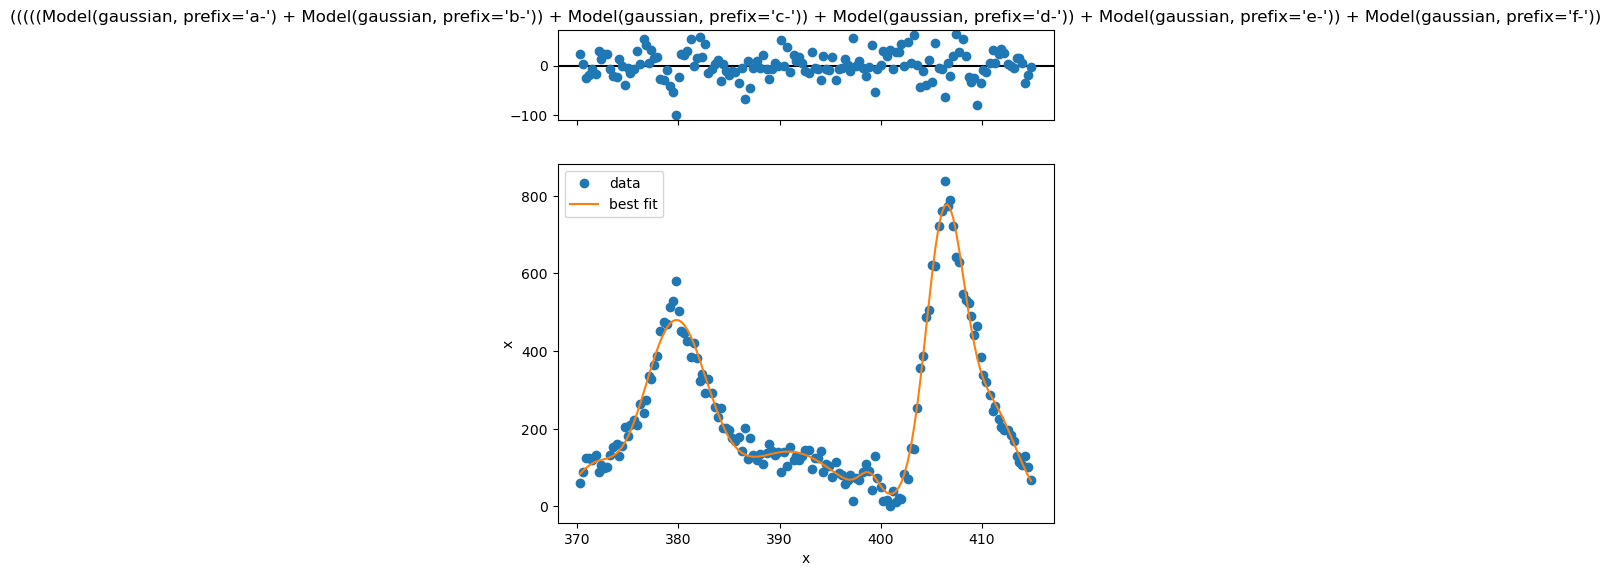

In [7]:
# test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
# test_curve = remove_shirley_background(test_curve)

selection = df['Energy(meas)'].between(370, 415, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)
#test_curve = remove_shirley_background(test_curve)

test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + GaussianModel(prefix="c_") + GaussianModel(prefix="d_") + GaussianModel(prefix="e_") + GaussianModel(prefix="f_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
        "a_center": {"value": 405 },
        "a_sigma": {"value": 1.5, "max": 2.5, "min": 1.4},
        "a_amplitude": {"min": 0},
        "b_center": {"value": 375},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 398, "max": 399, "min":397},
        "c_amplitude": {"min": 0.3},
        "c_sigma":{"max": 3, "min": 1},
        "d_center": {"value": 393, "max": 396, "min":391},
        "d_amplitude": {"min": 0},
        "d_sigma":{"max": 10, "min": 1},
        "e_center": {"value": 413, "max": 415, "min":411},
        "e_amplitude": {"min": 0},
        "e_sigma":{"max": 10, "min": 1},
        "f_center": {"value": 373, "max": 374, "min":370},
        "f_amplitude": {"min": 0},
        "f_sigma":{"max": 10, "min": 1},
    }

)
result.plot()
result

In [8]:
print(result.fit_report())

[[Model]]
    (((((Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')) + Model(gaussian, prefix='c_')) + Model(gaussian, prefix='d_')) + Model(gaussian, prefix='e_')) + Model(gaussian, prefix='f_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1139
    # data points      = 151
    # variables        = 18
    chi-square         = 119587.879
    reduced chi-square = 899.156986
    Akaike info crit   = 1043.85357
    Bayesian info crit = 1098.16460
    R-squared          = 0.97754655
[[Variables]]
    a_amplitude:  3502.90252 +/- 374.900142 (10.70%) (init = 0)
    a_center:     406.363724 +/- 0.15629925 (0.04%) (init = 405)
    a_sigma:      1.89146430 +/- 0.08775469 (4.64%) (init = 1.5)
    b_amplitude:  3753.25305 +/- 230.914665 (6.15%) (init = 0)
    b_center:     379.728868 +/- 0.12327111 (0.03%) (init = 375)
    b_sigma:      3.16242857 +/- 0.17772788 (5.62%) (init = 15.655)
    c_amplitude:  138.407507 +/- 73.6274891 (53.20%) (init = 0.3)
   

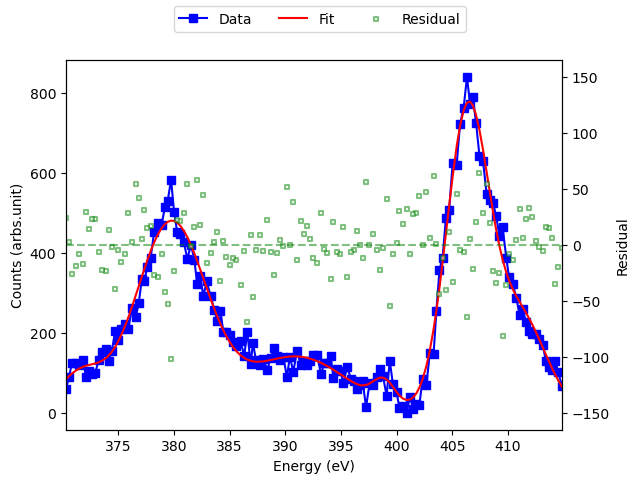

In [9]:
def plot_fit(model_result, ax=None):
    """Performs a straightforward plot of the data, residual, and fit to an axis."""
    if ax is None:
        fig, ax = plt.subplots()

    x = model_result.userkws[model_result.model.independent_vars[0]]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.axhline(0, color="green", linestyle="--", alpha=0.5)

    ax.plot(x, model_result.data, color="blue", marker="s", linewidth=1.5, label='Data')
    ax.plot(x, model_result.best_fit, color="red", linewidth=1.5, label='Fit')

    ax2.scatter(
        x,
        model_result.residual,
        edgecolors="green",
        alpha=0.5,
        s=12,
        marker="s",
        c="white",
        linewidth=1.5,
        label='Residual'
    )
    ylim = np.max(np.abs(np.asarray(ax2.get_ylim()))) * 1.5
    ax2.set_ylim([-ylim, ylim])
    ax.set_xlim([np.min(x), np.max(x)])
    ax2.set_ylabel('Residual')
    ax.set_ylabel('Counts (arbs.unit)')
    ax.set_xlabel('Energy (eV)')
    




fig, ax = plt.subplots(1,1)
plot_fit(result, ax=ax)

fig.legend(loc='upper center', ncol=3)